###Libraries

In [ ]:
# Importing required libraries
import glob
import tensorflow as tensorflow
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model, load_model
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from keras.utils.vis_utils import plot_model
from pylab import *
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import densenet
from sklearn.utils import class_weight

In [ ]:
# Connecting notebook with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Reading Data

In [ ]:
train_o = glob.glob("/content/drive/MyDrive/WasteData/TRAIN/O/*.jpg")
test_o = glob.glob("/content/drive/MyDrive/WasteData/TEST/O/*.jpg")
train_r = glob.glob("/content/drive/MyDrive/WasteData/TRAIN/R/*.jpg")
test_r = glob.glob("/content/drive/MyDrive/WasteData/TEST/R/*.jpg")
print("Total Number of Training Images",len(train_o)+len(train_r))
print("Total Number of Test Images",len(test_o)+len(test_r))
print("Total Number of Organic Train Images: ", len(train_o))
print("Total Number of Organic Test Images: ", len(test_o))
print("Total Number of Recycle Train Images: ", len(train_r))
print("Total Number of Recycle Test Images: ", len(test_r))

Total Number of Training Images 22564
Total Number of Test Images 2513
Total Number of Organic Train Images:  12565
Total Number of Organic Test Images:  1401
Total Number of Recycle Train Images:  9999
Total Number of Recycle Test Images:  1112


Text(0.5, 1.0, 'Organic Vs Recyclable')

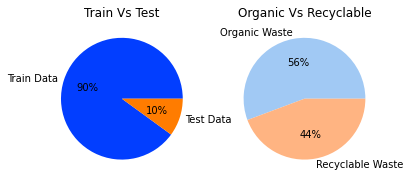

In [ ]:
plt.subplot(1, 2, 1) 
plt.pie([len(train_o)+len(train_r),len(test_o)+len(test_r)], labels = ['Train Data', 'Test Data'],colors = sns.color_palette('bright'), autopct='%.0f%%')
plt.title("Train Vs Test")
plt.subplot(1, 2, 2) 
plt.pie([len(train_o),len(train_r)], labels = ['Organic Waste', 'Recyclable Waste'],colors = sns.color_palette('pastel'), autopct='%.0f%%')
plt.title("Organic Vs Recyclable")

###Data Augmentation

In [ ]:
# Defining Data Augmentation
train_datagenerator = ImageDataGenerator(rescale = 1.0 / 255.0,
                                         horizontal_flip = True,
                                         vertical_flip = True,
                                         zoom_range = 0.6,
                                         rotation_range = 12,
                                         validation_split = 0.2,)

valid_datagengenerator = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagengenerator  = ImageDataGenerator(rescale = 1.0 / 255.0)

###Importing Data

In [ ]:
#loading train data
train  = train_datagenerator.flow_from_directory(directory = '/content/drive/MyDrive/WasteData/TRAIN',
                                                   target_size = (224,224),
                                                   shuffle = True,
                                                   class_mode = 'binary',
                                                   batch_size = 64, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


In [ ]:
#loading validation data 
val = valid_datagengenerator.flow_from_directory(directory = '/content/drive/MyDrive/WasteData/TRAIN',
                                                  target_size = (224,224),
                                                  shuffle = True,
                                                  class_mode = 'binary',
                                                  batch_size = 64, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [ ]:
#loading test data 
test = test_datagengenerator.flow_from_directory(directory = '/content/drive/MyDrive/WasteData/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 32,
                                             shuffle = False)

Found 2513 images belonging to 2 classes.


In [ ]:
train_y=train.classes
test_y=test.classes
val_y=val.classes

100%|██████████| 5/5 [01:49<00:00, 21.84s/it]


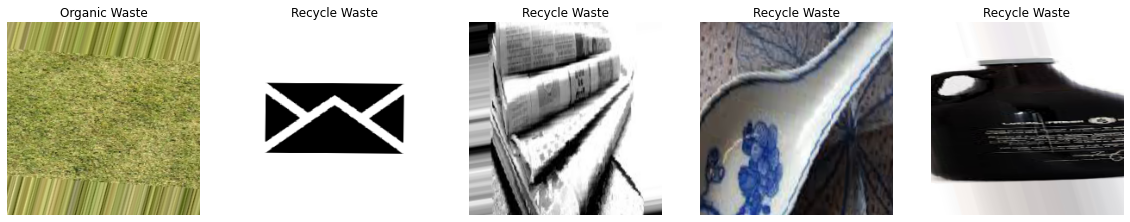

In [ ]:
# Samples from data
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train))
    rand2 = np.random.randint(40)
    ax[i].imshow(train[rand1][0][rand2])
    ax[i].axis('off')
    label = train[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

###Transfer Learning VGG16 MOdel

In [ ]:
#Model Definition
vgg16_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#Freeze Layers
for layer in vgg16_model.layers:
    layer.trainable=False

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining Layers for our transfer learning model

tl_vgg16_model=Sequential()
tl_vgg16_model.add(vgg16_model)
tl_vgg16_model.add(Dropout(0.3))
tl_vgg16_model.add(Flatten())
tl_vgg16_model.add(BatchNormalization())
tl_vgg16_model.add(Dense(1024,kernel_initializer='he_uniform'))
tl_vgg16_model.add(BatchNormalization())
tl_vgg16_model.add(Activation('relu'))
tl_vgg16_model.add(Dropout(0.2))
tl_vgg16_model.add(Dense(512,kernel_initializer='he_uniform'))
tl_vgg16_model.add(BatchNormalization())
tl_vgg16_model.add(Activation('relu'))
tl_vgg16_model.add(Dropout(0.1))
tl_vgg16_model.add(Dense(1,activation='sigmoid'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

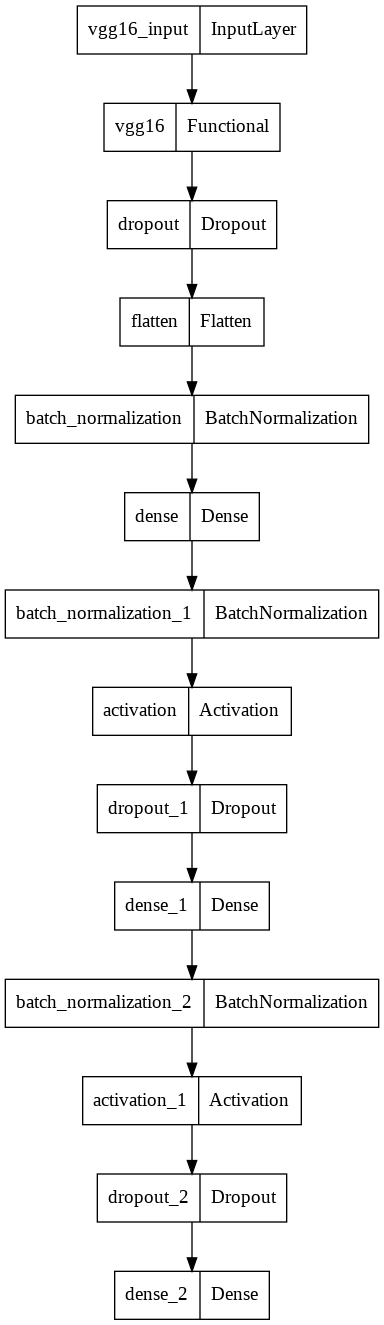

In [ ]:
#Summry of our transfer learning vgg16 model
tl_vgg16_model.summary()
plot_model(tl_vgg16_model, to_file='vgg16.png')

In [ ]:
#Model Compilation using Adam Optiminzer with learing rate 0.001
adam_opt    = tensorflow.keras.optimizers.Adam(lr=0.001)

tl_vgg16_model.compile(optimizer=adam_opt,
                       loss='binary_crossentropy',
                       metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
                      )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#defining callbacks
filepath = '/content/drive/MyDrive/VGG16Class/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
#Model Training
tl_vgg16_model_fit=tl_vgg16_model.fit(train,
                                      steps_per_epoch = len(train),
                                      validation_data=val,
                                      validation_steps = len(val),
                                      epochs = 20,
                                      callbacks = callback_list,
                                      verbose = 1)

Epoch 1/20
283/283 [==============================] - ETA: 0s - loss: 0.3644 - auc: 0.9197 
Epoch 1: val_auc improved from -inf to 0.94579, saving model to /content/drive/MyDrive/VGG16Class/best_weights.hdf5
283/283 [==============================] - 7029s 25s/step - loss: 0.3644 - auc: 0.9197 - val_loss: 0.2892 - val_auc: 0.9458
Epoch 2/20
283/283 [==============================] - ETA: 0s - loss: 0.3031 - auc: 0.9433
Epoch 2: val_auc improved from 0.94579 to 0.95391, saving model to /content/drive/MyDrive/VGG16Class/best_weights.hdf5
283/283 [==============================] - 247s 873ms/step - loss: 0.3031 - auc: 0.9433 - val_loss: 0.2717 - val_auc: 0.9539
Epoch 3/20
283/283 [==============================] - ETA: 0s - loss: 0.2790 - auc: 0.9517
Epoch 3: val_auc did not improve from 0.95391
283/283 [==============================] - 243s 858ms/step - loss: 0.2790 - auc: 0.9517 - val_loss: 0.2856 - val_auc: 0.9517
Epoch 4/20
283/283 [==============================] - ETA: 0s - loss: 0

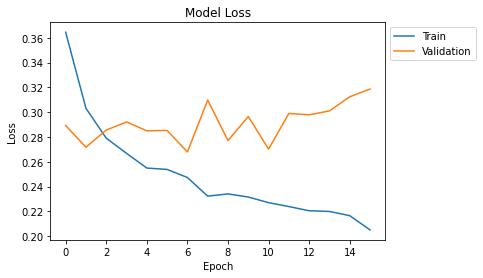

In [ ]:
plt.plot(tl_vgg16_model_fit.history['loss'])
plt.plot(tl_vgg16_model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

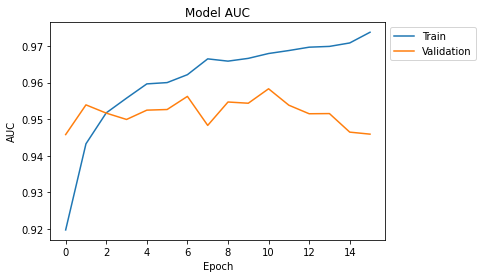

In [ ]:
plt.plot(tl_vgg16_model_fit.history['auc'])
plt.plot(tl_vgg16_model_fit.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Saving the model
tl_vgg16_model.save('/content/drive/MyDrive/VGG16/VggNew')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VGG16/VggNew/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VGG16/VggNew/assets


In [ ]:
#loading save model
reconstructed_model_vgg16 = keras.models.load_model('/content/drive/MyDrive/VGG16/VggNew')

In [ ]:
# Calculating loss and AUC for test data
loss, AUC = reconstructed_model_vgg16.evaluate(test)
print("Test dataset AUC: %f and Loss: %f" % (AUC,loss))

79/79 [==============================] - 339s 4s/step - loss: 0.3457 - auc: 0.9457
Test dataset AUC: 0.945737 and Loss: 0.345722


In [ ]:
# Performing prediction on test data
tl_vgg_model_pred = reconstructed_model_vgg16.predict(test)
tl_vgg_model_pred_list = [int(i > .5) for i in tl_vgg_model_pred]

Text(0.5, 15.0, 'True label')

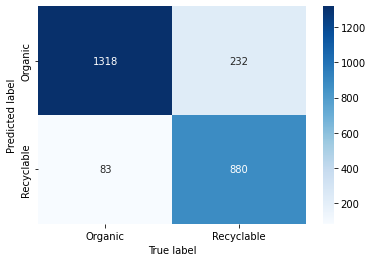

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(
        confusion_matrix(tl_vgg_model_pred_list,test_y), index=['Organic','Recyclable'], columns=['Organic','Recyclable'], 
    )
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Predicted label')
plt.xlabel('True label')

In [ ]:
print(classification_report(tl_vgg_model_pred_list,test_y ,target_names=['Organic', 'Recyclable']))

              precision    recall  f1-score   support

     Organic       0.94      0.85      0.89      1550
  Recyclable       0.79      0.91      0.85       963

    accuracy                           0.87      2513
   macro avg       0.87      0.88      0.87      2513
weighted avg       0.88      0.87      0.88      2513



Object in the image is Organic waste


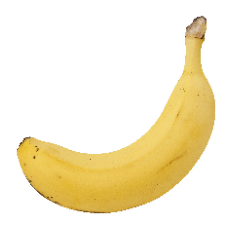

In [ ]:
test_image = load_img('/content/drive/MyDrive/TestImageForClassificationAndSegmentation/Bananaimage.jpeg', target_size=(224,224))
test_image = img_to_array(test_image)
test_image = test_image / 255
imshow(test_image)
plt.axis('off')
test_image = np.expand_dims(test_image,axis=0)
prediction = reconstructed_model_vgg16.predict(test_image)

if prediction[0][0] > 0.5:
    print("Object in the image is Recycalable waste")
else:
    print("Object in the image is Organic waste")

Object in the image is Organic waste


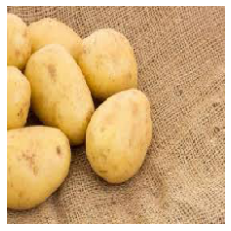

In [ ]:
test_image = load_img('/content/drive/MyDrive/WasteData/TEST/O/O_12968.jpg', target_size=(224,224))
test_image = img_to_array(test_image)
test_image = test_image / 255
imshow(test_image)
plt.axis('off')
test_image = np.expand_dims(test_image,axis=0)
prediction = reconstructed_model_vgg16.predict(test_image)

if prediction[0][0] > 0.5:
    print("Object in the image is Recycalable waste")
else:
    print("Object in the image is Organic waste")

Object in the image is Recycalable waste


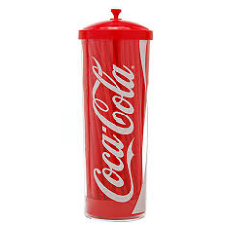

In [ ]:
test_image = load_img('/content/drive/MyDrive/WasteData/TEST/R/R_10470.jpg', target_size=(224,224))
test_image = img_to_array(test_image)
test_image = test_image / 255
imshow(test_image)
plt.axis('off')
test_image = np.expand_dims(test_image,axis=0)
prediction = reconstructed_model_vgg16.predict(test_image)

if prediction[0][0] > 0.5:
    print("Object in the image is Recycalable waste")
else:
    print("Object in the image is Organic waste")

Object in the image is Recycalable waste


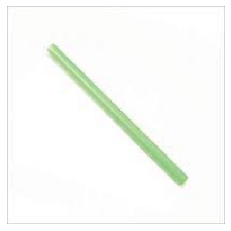

In [ ]:
test_image = load_img('/content/drive/MyDrive/WasteData/TEST/R/R_10499.jpg', target_size=(224,224))
test_image = img_to_array(test_image)
test_image = test_image / 255
imshow(test_image)
plt.axis('off')
test_image = np.expand_dims(test_image,axis=0)
prediction = reconstructed_model_vgg16.predict(test_image)

if prediction[0][0] > 0.5:
    print("Object in the image is Recycalable waste")
else:
    print("Object in the image is Organic waste")

###DenseNet 121


In [ ]:
train_datagen_dense = ImageDataGenerator(validation_split = 0.2)

valid_datagen_dense = ImageDataGenerator(validation_split = 0.2)

test_datagen_dense  = ImageDataGenerator()

In [ ]:
#loading train data for densenet 
train_dense  = train_datagen_dense.flow_from_directory(directory = '/content/drive/MyDrive/WasteData/TRAIN',
                                                   target_size = (224,224),
                                                   shuffle = True,
                                                   class_mode = 'binary',
                                                   batch_size = 64, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


In [ ]:
#loading validation data for densenet 
val_dense = valid_datagen_dense.flow_from_directory(directory = '/content/drive/MyDrive/WasteData/TRAIN',
                                                  target_size = (224,224),
                                                  shuffle = True,
                                                  class_mode = 'binary',
                                                  batch_size = 64, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [ ]:
#loading test data for densenet
test_dense = test_datagen_dense.flow_from_directory(directory = '/content/drive/MyDrive/WasteData/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 32,
                                             shuffle = False)

Found 2513 images belonging to 2 classes.


In [ ]:
# Importing pre trained densenent model 
densenet121_pretrained = densenet.DenseNet121(include_top=False,weights='imagenet',
                           input_shape=(224,224,3),pooling='avg')

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
#freezing the layers
for layer in densenet121_pretrained.layers:
    layer.trainable=False

In [ ]:
#Defining callbacks for densenet 
filepath = '/content/drive/MyDrive/VGG16Class/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
#Defining layers for densenet model 
tl_densenet121_model=Sequential()
tl_densenet121_model.add(densenet121_pretrained)
tl_densenet121_model.add(Flatten())
tl_densenet121_model.add(BatchNormalization())
tl_densenet121_model.add(Dense(128,kernel_initializer='he_uniform'))
tl_densenet121_model.add(Activation('relu'))
tl_densenet121_model.add(BatchNormalization())
tl_densenet121_model.add(Dense(64,kernel_initializer='he_uniform'))
tl_densenet121_model.add(Activation('relu'))
tl_densenet121_model.add(Dense(1,activation='sigmoid'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 128)               131200    
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                      

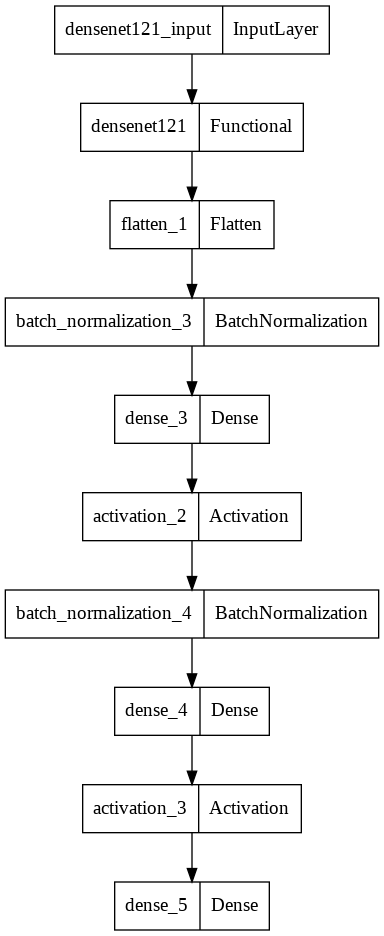

In [ ]:
tl_densenet121_model.summary()
plot_model(tl_densenet121_model, to_file='Densenet121.png')

In [ ]:
# Compiling the model using adam optimizer 
tl_densenet121_model.compile(optimizer='adam',
                             loss='binary_crossentropy', 
                             metrics=[tensorflow.keras.metrics.AUC(name = 'auc')])

In [ ]:
# Training desenet model 
tl_densenet121_model_fit = tl_densenet121_model.fit(train_dense,
                                      steps_per_epoch = len(train_dense),
                                      validation_data=val_dense,
                                      validation_steps = len(val_dense),
                                      epochs = 20,
                                      callbacks = callback_list,
                                      verbose = 1)

In [ ]:
#saving the model
tl_densenet121_model.save('/content/drive/MyDrive/VGG16/DenseNew')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VGG16/DenseNew/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VGG16/DenseNew/assets


In [ ]:
# Loading the saved model
reconstructed_model_densenet121 = keras.models.load_model('/content/drive/MyDrive/VGG16/DenseNew')

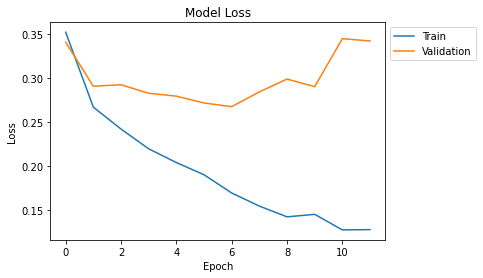

In [ ]:
plt.plot(tl_densenet121_model_fit.history['loss'])
plt.plot(tl_densenet121_model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

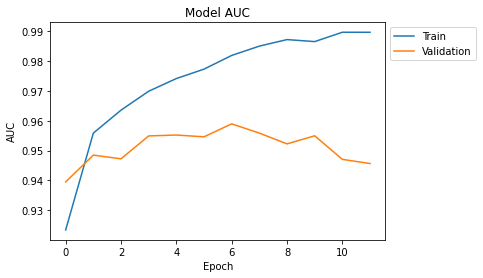

In [ ]:
plt.plot(tl_densenet121_model_fit.history['auc'])
plt.plot(tl_densenet121_model_fit.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# calculating loss and AUC for test data
loss, AUC = reconstructed_model_densenet121.evaluate(test_dense)
print("Test dataset AUC: %f and Loss: %f" % (AUC,loss))

79/79 [==============================] - 12s 126ms/step - loss: 0.2969 - auc: 0.9619
Test dataset AUC: 0.961853 and Loss: 0.296869


In [ ]:
#Performing prediction on test data 
tl_densenet121_model_pred = reconstructed_model_densenet121.predict(test_dense)
tl_densenet121_model_pred_list = [int(i > .5) for i in tl_densenet121_model_pred]

Text(0.5, 15.0, 'True label')

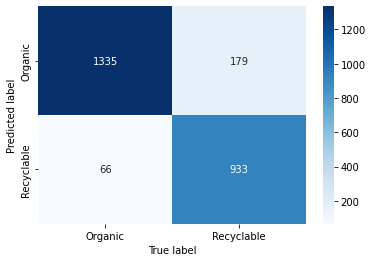

In [ ]:
#Confusion matrix
import seaborn as sns
df_cm = pd.DataFrame(
        confusion_matrix(tl_densenet121_model_pred_list,test_dense.classes), index=['Organic','Recyclable'], columns=['Organic','Recyclable'], 
    )
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Predicted label')
plt.xlabel('True label')

In [ ]:
print(classification_report(tl_densenet121_model_pred_list,test_dense.classes, target_names=['Organic', 'Recyclable']))

              precision    recall  f1-score   support

     Organic       0.95      0.88      0.92      1514
  Recyclable       0.84      0.93      0.88       999

    accuracy                           0.90      2513
   macro avg       0.90      0.91      0.90      2513
weighted avg       0.91      0.90      0.90      2513



Object in the image is Organic waste


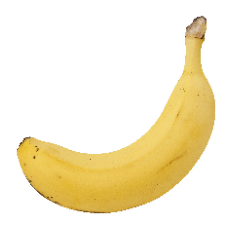

In [ ]:
test_image = load_img('/content/drive/MyDrive/TestImageForClassificationAndSegmentation/Bananaimage.jpeg', target_size=(224,224))
test_image = img_to_array(test_image)
test_image = test_image / 255
imshow(test_image)
plt.axis('off')
test_image = np.expand_dims(test_image,axis=0)
prediction = reconstructed_model_densenet121.predict(test_image)

if prediction[0][0] > 0.5:
    print("Object in the image is Recycalable waste")
else:
    print("Object in the image is Organic waste")

Object in the image is Organic waste


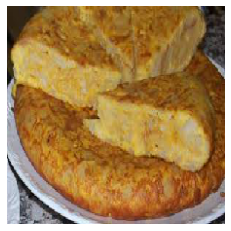

In [ ]:
test_image = load_img('/content/drive/MyDrive/WasteData/TEST/O/O_13175.jpg', target_size=(224,224))
test_image = img_to_array(test_image)
test_image = test_image / 255
imshow(test_image)
plt.axis('off')
test_image = np.expand_dims(test_image,axis=0)
prediction = reconstructed_model_densenet121.predict(test_image)

if prediction[0][0] > 0.5:
    print("Object in the image is Recycalable waste")
else:
    print("Object in the image is Organic waste")

Object in the image is Recycalable waste


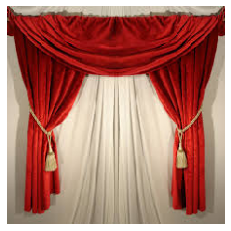

In [ ]:
test_image = load_img('/content/drive/MyDrive/WasteData/TEST/R/R_10000.jpg', target_size=(224,224))
test_image = img_to_array(test_image)
test_image = test_image / 255
imshow(test_image)
plt.axis('off')
test_image = np.expand_dims(test_image,axis=0)
prediction = reconstructed_model_densenet121.predict(test_image)

if prediction[0][0] > 0.5:
    print("Object in the image is Recycalable waste")
else:
    print("Object in the image is Organic waste")

Object in the image is Recycalable waste


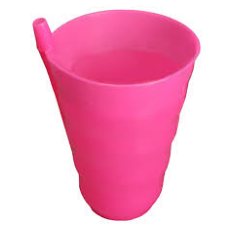

In [ ]:
test_image = load_img('/content/drive/MyDrive/WasteData/TEST/R/R_10430.jpg', target_size=(224,224))
test_image = img_to_array(test_image)
test_image = test_image / 255
imshow(test_image)
plt.axis('off')
test_image = np.expand_dims(test_image,axis=0)
prediction = reconstructed_model_densenet121.predict(test_image)

if prediction[0][0] > 0.5:
    print("Object in the image is Recycalable waste")
else:
    print("Object in the image is Organic waste")